In [205]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import ast
from pedal import * 

# Helper functions and data
During a lot of the analysis I ended up doing, I noticed I was repeating code. I defined these functions to help decompose and organize my analysis. 

In [206]:
clear_report()
def get_called_function(node):
    # use Pedal to get called function 
    if node.ast_name == "Attribute":
        left = get_called_function(node.value)
        right = node.attr
        return f"{left}.{right}"
    elif node.ast_name == "Name":
        return node.id
def make_cont_tables(df, headers): 
    # make contingency tables for each survey based on prior experience.
    for header in headers: 
        print(header + ' totals and contingency table based on prior experience')
        print(df[header].str.strip().str.lower().value_counts())
        display(make_exp_table(df, header))
    
def make_table_by_q(df, header):
    # make frequency table for one question sliced by survey version
    print(header + ' contingency table')
    table = (pd.crosstab(df.Version, df[header], margins = True))
    # display(table)
    return table

def make_exp_table(df, header): 
    # make frequency table for one question sliced by prior experience
    print(header + ' by experience')
    table = pd.crosstab([df.Prior, df.PriorGameDev], df[header].str.lower().str.strip(), margins=True)
    # display(table)
    return table
        
def perform_all_chi(df, headers): 
    # perform chi-square independence test on each question sliced by survey version.
    p_values = []
    for header in headers: 
        cont_tbl = pd.crosstab(df['Version'], df[header], margins=False)
        chi = st.chi2_contingency(cont_tbl.values.tolist())
        p_values.append(chi[1])
    return p_values
    
def perform_exp_chi(df, headers): 
    # perform chi-square indpendence test on each question sliced by experience.
    p_values = []
    for header in headers:
        cont_tbl = pd.crosstab([df.Prior, df.PriorGameDev], df[header], margins = False)
        chi = st.chi2_contingency(cont_tbl.values.tolist())
        p_values.append(chi[1])
    return p_values

def analyze_free_response(df, header, exp): 
    # analyze free response questions 
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    if exp: 
        table = make_exp_table(df, header)
        table = table.drop('All', axis=1).dropna().sort_values(('All',''), axis=1, ascending=False)
    else: 
        table = make_table_by_q(df, header)
        table = table.drop('All', axis=1).sort_values(by='All', axis=1, ascending=False)
    
    return table

def analyze_open_end(df, header):
    # analyze open ended code 
    total = {
        'methods': 0,
        'functions': 0,
        'both': 0,
        'test cases': 0,
        'graphics': 0,
        'pens': 0,
        'for': 0,
        'while': 0, 
        'if': 0,
        'func def': 0
    }
    for code in df[header]:
        methods = False
        functions = False
        clear_report()
        code = str(code)
        calls = find_asts("Call", code)
        num_for = len(find_asts("For", code))
        num_while = len(find_asts("While", code))
        called_functions = [get_called_function(c.func) for c in calls]
        for c in calls:   
            if c.func.ast_name == "Name":
                methods = True
            if c.func.ast_name == "Attribute":
                functions = True    
        if functions & methods:
            total['both'] += 1
            methods = 0
            functions = 0
        if methods:
            total['methods'] += 1
        if functions:
            total['functions'] += 1
        if "assert_equal" in code:
            total['test cases'] += 1
        if "graphics" in code:
            total['graphics'] += 1
        if " pen" in code:
            total['pens'] += 1
        if 'if' in code:
            total['if'] += 1
        if 'def' in code:
            total['func def'] += 1
        if num_for != 0: 
            total['for'] += 1
        if num_while != 0:
            total['while'] += 1
    lines_char = avg_lines_char(df, header)
    show_line_char_graph_calc(lines_char)
    analyze_open_code(df)
    return total

def chi_per_version(headers): 
    for header in headers:
        cont_tbl = pd.crosstab([v1.Prior, v1.PriorGameDev], v1[header], margins = False)
        chi = st.chi2_contingency(cont_tbl.values.tolist())
        print(f"p-value of v1 based on prior experience: {chi[1]}")
        cont_tbl = pd.crosstab([v2.Prior, v2.PriorGameDev], v2[header], margins = False)
        chi = st.chi2_contingency(cont_tbl.values.tolist())
        print(f"p-value of v2 based on prior experience: {chi[1]}")
         

def clean_text(text):
    text = str(text)
    text.lower()
    if 'def' in text:
        text = text.replace('def', '')
    if '()' in text:
        text = text.replace('()', '')
    if text[-1] == 's':
        text = text[:-1]
    text = text.strip()
    return text
    
def analyze_open_code(df): 
    student_programs = df['GameDevOpenCode']
    broken, working = 0, 0
    for program in student_programs:
        try:
            program = str(program)
            ast.parse(program)
            working += 1
        except SyntaxError:
            broken += 1
    print(f"\nBroken: {broken}; Working: {working}")
    
def show_line_char_graph_calc(lines_char):
    plt.hist(lines_char[0])
    plt.title("distribution of number of lines per response")
    plt.show()
    plt.hist(lines_char[1])
    plt.title("distribution of length of repsonse (in characters)")
    plt.show()
    lines_stat, line_p = st.shapiro(lines_char[0])
    char_stat, char_p = st.shapiro(lines_char[1])
    print("Num Lines Normality on an interval of .05: ", lines_stat, line_p, line_p < 0.05)
    print("Num Characters Normality on an interval of .05: ", char_stat, char_p, char_p < 0.05)

def avg_lines_char(df, header): 
    lines_count = 0
    char_count = 0
    student_codes = df[header].dropna()
    num_codes = len(student_codes)
    lines_all = []
    char_all = []
    for code in student_codes:
        code = str(code)
        len_code = len(code)
        lines = (code.count('\n') + 1)
        lines_count += lines
        char_count += len_code
        lines_all.append(lines)
        char_all.append(len_code)
    lines_avg = lines_count / num_codes
    char_avg = char_count / num_codes
    return [lines_all, char_all]

### Analysis process
My data comes from two surveys, which I will refer to as survey version one and two. Analysis will be done on each survey individually. Then testing will be conducted to determine when it is appropriate to combine survey results.

### Visualizations 
I struggled to decide when to focus on visualizations. I initially used them briefly to determine distribution of the open-ended question. I decided to wait until I understood what my data suggests to focus on visualizations. I made this decision because visualizations should help communicate findings, and I did not know what my data was communicating as I analyzed it. After initial analysis, I went through and tried some different visualizations to see what looked best with the data. I Zoomed with some friends who helped me brainstorm which visuals would be most helpful - which proved to be especially challenging to decide for some of the results sliced multiple ways. I used [this source](https://blog.datawrapper.de/which-color-scale-to-use-in-data-vis/#categorical-color-scales) to determine that I should use different colored hues considering my data is categorical - different hues suggest distinct categories. 

# Data Cleaning Survey v1
Load fall 2020 survey 1 data from CSV file.

In [207]:
v1 = pd.read_csv('f20_game_dev_library_data.csv')
v1 = v1.drop(columns=['FinalGrade', 'Midterm', 'CanvasGrade', 'Section', 'Lab', 'TAEngagement', 'TACommunication', 'MeanDiffRank', 'Points', 'Hours Spent in BlockPy', 'Median # of Days Submitted Before Due Date', 'Number of Days Spent Working', 'Assignments With 0s', 'Native Speaker?', 'Location', 'Race/Ethnicity', 'coarse_race', 'PointsGrade', 'MockMidterm14', 'Level', 'OpenPython', 'OpenCode'])

Drop rows without survey responses. Filter prior game development experience to yes or no. 

In [208]:
v1 = v1.dropna(subset=['PriorGameDev'])
v1['PriorGameDev'] = v1['PriorGameDev'].mask(v1['PriorGameDev'] != 'No.', 'Yes.')

define List of headers in both surveys

In [209]:
survey_headers = ['OpenShape', 'OpenScreen', 'ClosedScreen', 'OpenMovement', 'ClosedMovement', 'ClosedWave', 'ClosedStep', 'ClosedEvent', 'ClosedState', 'OpenSprite',
                 'ClosedSprite']

# Data Analysis Survey v1
Make table observing distribution of experience levels. 

PriorGameDev,No.,Yes.
Prior,,
False,19,1
True,21,35


[19  1 21 35]


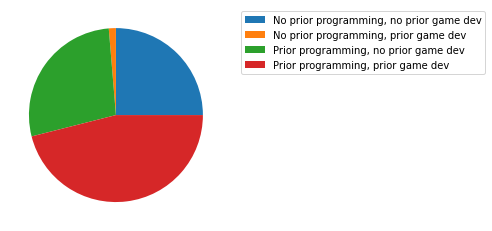

In [210]:
v1_dist = pd.crosstab(v1['Prior'], v1['PriorGameDev'], margins=False)
display(v1_dist)
# v1_dist.groupby(['Prior']).sum().plot.pie(y='No.') -> doesn't show all 4 groups
# v1_dist.sum().plot.pie() -> sums up entire columns, doesn't show all 4 groups
pi_wedges = v1_dist.groupby(['Prior', 'PriorGameDev']).sum().values.flatten()
print(pi_wedges)
wedge_labels = ['No prior programming, no prior game dev', 'No prior programming, prior game dev', 'Prior programming, no prior game dev', 'Prior programming, prior game dev']
# ah got it, gets and flattens 2d array into 1d array that can be passed to matplotlib pyplot
plt.pie(x=pi_wedges)
plt.legend(wedge_labels, bbox_to_anchor=(1.05, 1))
plt.show()

Make contingency tables of prior experience levels and survey responses.

In [211]:
make_cont_tables(v1, survey_headers)

OpenShape totals and contingency table based on prior experience
draw_rectangle                                    13
make_rectangle                                    11
rectangle                                         11
create_rectangle                                   6
draw_square                                        3
rect                                               2
generate_rectangle                                 2
draw_rectangle()                                   2
square                                             2
draw_square()                                      1
generate_square                                    1
integer                                            1
def create_rectangle                               1
def draw_rectangle                                 1
create_shape                                       1
shapes                                             1
rectangle_shape                                    1
g_rectangle                       

OpenShape           a_rectangle  black_rectangle  create_rectangle  \
Prior PriorGameDev                                                   
False No.                     1                0                 1   
      Yes.                    0                0                 0   
True  No.                     0                1                 2   
      Yes.                    0                0                 3   
All                           1                1                 6   

OpenShape           create_shape  cuboid  def create_rectangle  def draw_rect  \
Prior PriorGameDev                                                              
False No.                      0       1                     1              0   
      Yes.                     0       0                     0              0   
True  No.                      1       0                     0              0   
      Yes.                     0       0                     0              1   
All                            1       1                     1              1   

OpenShape           def draw_rectangle  \
Prior PriorGameDev                       
False No.                            0   
      Yes.                           0   
True  No.                            0   
      Yes.                           1   
All                                  1   

OpenShape           def rectangle(length: int, width: int) -> int:  \
Prior PriorGameDev                                                   
False No.                                                        0   
      Yes.                                                       0   
True  No.                                                        0   
      Yes.                                                       1   
All                                                              1   

OpenShape           def rectangle_shape(shape: str)->str:  draw_rectangle  \
Prior PriorGameDev                                                          
False No.                                               0               0   
      Yes.                                              0               0   
True  No.                                               1               5   
      Yes.                                              0               8   
All                                                     1              13   

OpenShape           draw_rectangle()  draw_square  draw_square()  \
Prior PriorGameDev                                                 
False No.                          0            1              0   
      Yes.                         0            0              0   
True  No.                          0            0              1   
      Yes.                         2            2              0   
All                                2            3              1   

OpenShape           firstrectangle  g_rectangle  generate.rectangle  \
Prior PriorGameDev                                                    
False No.                        1            1                   1   
      Yes.                       0            0                   0   
True  No.                        0            0                   0   
      Yes.                       0            0                   0   
All                              1            1                   1   

OpenShape           generate_rect  generate_rectangle  generate_square  \
Prior PriorGameDev                                                       
False No.                       0                   1                0   
      Yes.                      0                   0                0   
True  No.                       1                   1                0   
      Yes.                      0                   0                1   
All                             1                   2                1   

OpenShape           integer  make_box  make_rect  make_rectangle  \
Prior PriorGameDev                                   

OpenScreen totals and contingency table based on prior experience
border                                       28
frame                                         6
the border                                    4
borders                                       3
boarder                                       2
perimeter                                     2
window                                        2
edge                                          2
insider of the square                         1
the boarder                                   1
area_of_game                                  1
outs puts                                     1
yellow_border                                 1
outer border                                  1
the boundary                                  1
window, frame, or camera area                 1
yellow_game_border                            1
marginal area                                 1
outline                                       1
frog                  

OpenScreen          (the_height_length:int, width_length:int)  a border  \
Prior PriorGameDev                                                        
False No.                                                   1         1   
      Yes.                                                  0         0   
True  No.                                                   0         0   
      Yes.                                                  0         0   
All                                                         1         1   

OpenScreen          an outline  area_of_game  background or border  boarder  \
Prior PriorGameDev                                                            
False No.                    1             0                     0        0   
      Yes.                   0             0                     0        0   
True  No.                    0             1                     0        0   
      Yes.                   0             0                     1        2   
All                          1             1                     1        2   

OpenScreen          border  borderlines  borders  bounds  edge  frame  frog  \
Prior PriorGameDev                                                            
False No.                3            1        0       0     2      2     0   
      Yes.               0            0        0       0     0      0     1   
True  No.                6            0        1       0     0      3     0   
      Yes.              19            0        2       1     0      1     0   
All                     28            1        3       1     2      6     1   

OpenScreen          game perimeter  game_window  insider of the square  \
Prior PriorGameDev                                                       
False No.                        0            0                      1   
      Yes.                       0            0                      0   
True  No.                        0            0                      0   
      Yes.                       1            1                      0   
All                              1            1                      1   

OpenScreen          margin  marginal area  outer border  outer_border  \
Prior PriorGameDev                                                      
False No.                1              1             0             0   
      Yes.               0              0             0             0   
True  No.                0              0             1             1   
      Yes.               0              0             0             0   
All                      1              1             1             1   

OpenScreen          outline  outs puts  perimeter  screen  the boarder  \
Prior PriorGameDev                                                       
False No.                 0          1          1       1            1   
      Yes.                0          0          0       0            0   
True  No.                 1          0          1       0            0   
      Yes.                0          0          0       0            0   
All                       1          1          2       1            1   

OpenScreen          the border  the boundary  the frame or boundaries  \
Prior PriorGameDev                                                      
False No.                    0             0                        1   
      Yes.                   0             0                        0   
True  No.                    2             0                        0   
      Yes.                   2             1                        0   
All                          4             1                        1   

OpenScreen          the game border  visuals  wall  window  \
Prior PriorGameDev                                           
False No.                         0        0     0       0   
      Yes.                        0        0     0       0   
True  No.                         1        1     0      

ClosedScreen totals and contingency table based on prior experience
screen    30
view      23
scene     15
world      4
camera     2
level      2
Name: ClosedScreen, dtype: int64
ClosedScreen by experience


ClosedScreen        camera  level  scene  screen  view  world  All
Prior PriorGameDev                                                
False No.                2      1      3       6     4      3   19
      Yes.               0      0      0       1     0      0    1
True  No.                0      1      3      10     7      0   21
      Yes.               0      0      9      13    12      1   35
All                      2      2     15      30    23      4   76

OpenMovement totals and contingency table based on prior experience
moving                                                                                         8
floating                                                                                       6
walking                                                                                        6
sliding                                                                                        6
move                                                                                           5
gliding                                                                                        5
move_right                                                                                     2
walk                                                                                           2
moveright                                                                                      1
repositioning                                              

OpenMovement        animation  changing the x value  \
Prior PriorGameDev                                    
False No.                   0                     0   
      Yes.                  0                     0   
True  No.                   0                     0   
      Yes.                  1                     1   
All                         1                     1   

OpenMovement        changing x position to the right, once it reaches a point it goes back to where it started.  \
Prior PriorGameDev                                                                                                
False No.                                                           0                                             
      Yes.                                                          0                                             
True  No.                                                           0                                             
      Yes.                                                          1                                             
All                                                                 1                                             

OpenMovement        constant horizontal translation  floating  forward  glide  \
Prior PriorGameDev                                                              
False No.                                         0         3        0      0   
      Yes.                                        0         0        0      0   
True  No.                                         0         2        0      0   
      Yes.                                        1         1        1      1   
All                                               1         6        1      1   

OpenMovement        gliding  go forward  \
Prior PriorGameDev                        
False No.                 1           0   
      Yes.                0           0   
True  No.                 1           0   
      Yes.                3           1   
All                       5           1   

OpenMovement        horizontal displacement（x move forward?)  \
Prior PriorGameDev                                             
False No.                                                  1   
      Yes.                                                 0   
True  No.                                                  0   
      Yes.                                                 0   
All                                                        1   

OpenMovement        hovering with forward momentum  move  move forward  \
Prior PriorGameDev                                                       
False No.                                        1     1             0   
      Yes.                                       0     0             0   
True  No.                                        0     2             1   
      Yes.                                       0     2             0   
All                                              1     5             1   

OpenMovement        move right  move to right  move.right  move_forward  \
Prior PriorGameDev                                                        
False No.                    0              0           0             0   
      Yes.                   0              0           0             0   
True  No.                    0              0           1             0   
      Yes.                   1              1           0             1   
All                          1              1           1             1   

OpenMovement        move_left  move_right  move_wizard_forward  moveforward  \
Prior PriorGameDev                                                            
False No.                   0           0                    1            0   
      Yes.                  0           0                    0            0   
True  No.                   0           0                    0            0   
      Yes.                  1           2        

ClosedMovement totals and contingency table based on prior experience
movement     33
glide        33
animation     7
action        3
Name: ClosedMovement, dtype: int64
ClosedMovement by experience


ClosedMovement      action  animation  glide  movement  All
Prior PriorGameDev                                         
False No.                2          1      8         8   19
      Yes.               0          0      0         1    1
True  No.                0          3     10         8   21
      Yes.               1          3     15        16   35
All                      3          7     33        33   76

ClosedWave totals and contingency table based on prior experience
action       34
animation    31
movement     11
Name: ClosedWave, dtype: int64
ClosedWave by experience


ClosedWave          action  animation  movement  All
Prior PriorGameDev                                  
False No.               10          5         4   19
      Yes.               1          0         0    1
True  No.                9         10         2   21
      Yes.              14         16         5   35
All                     34         31        11   76

ClosedStep totals and contingency table based on prior experience
repeat       38
iteration    24
step         12
update        2
Name: ClosedStep, dtype: int64
ClosedStep by experience


ClosedStep          iteration  repeat  step  update  All
Prior PriorGameDev                                      
False No.                   5      13     1       0   19
      Yes.                  0       1     0       0    1
True  No.                   8       6     6       1   21
      Yes.                 11      18     5       1   35
All                        24      38    12       2   76

ClosedEvent totals and contingency table based on prior experience
when        35
attach      13
connect     12
register     9
on           7
Name: ClosedEvent, dtype: int64
ClosedEvent by experience


ClosedEvent         attach  connect  on  register  when  All
Prior PriorGameDev                                          
False No.                4        6   1         1     7   19
      Yes.               0        1   0         0     0    1
True  No.                3        4   1         4     9   21
      Yes.               6        1   5         4    19   35
All                     13       12   7         9    35   76

ClosedState totals and contingency table based on prior experience
state     37
status    24
moment    15
Name: ClosedState, dtype: int64
ClosedState by experience


ClosedState         moment  state  status  All
Prior PriorGameDev                            
False No.               10      4       5   19
      Yes.               0      0       1    1
True  No.                4     10       7   21
      Yes.               1     23      11   35
All                     15     37      24   76

OpenSprite totals and contingency table based on prior experience
objects                         18
characters                      14
sprites                         11
elements                         4
animations                       2
element                          2
figures                          2
object                           1
pictures                         1
cartoons                         1
charecters                       1
game elements                    1
body of object                   1
player                           1
game pieces                      1
component                        1
item                             1
the player and the objective     1
foreground                       1
figure                           1
assets                           1
the verbs. values                1
sceneic_elements                 1
the subjects                     1
entities                         1
special point or movement        1
bubble                  

OpenSprite          animations  assets  body of object  bubble  cartoons  \
Prior PriorGameDev                                                         
False No.                    0       0               0       1         1   
      Yes.                   0       0               0       0         0   
True  No.                    1       1               1       0         0   
      Yes.                   1       0               0       0         0   
All                          2       1               1       1         1   

OpenSprite          character  characters  charecters  component  element  \
Prior PriorGameDev                                                          
False No.                   0           3           0          1        1   
      Yes.                  0           0           0          0        0   
True  No.                   0           5           0          0        0   
      Yes.                  1           6           1          0        1   
All                         1          14           1          1        2   

OpenSprite          elements  entities  figure  figures  foreground  \
Prior PriorGameDev                                                    
False No.                  2         0       1        0           0   
      Yes.                 0         0       0        0           0   
True  No.                  0         1       0        2           0   
      Yes.                 2         0       0        0           1   
All                        4         1       1        2           1   

OpenSprite          game elements  game pieces  item  key  object  objects  \
Prior PriorGameDev                                                           
False No.                       0            1     0    0       1        2   
      Yes.                      0            0     1    0       0        0   
True  No.                       0            0     0    1       0        7   
      Yes.                      1            0     0    0       0        9   
All                             1            1     1    1       1       18   

OpenSprite          pictures  player  sceneic_elements  \
Prior PriorGameDev                                       
False No.                  1       0                 0   
      Yes.                 0       0                 0   
True  No.                  0       0                 0   
      Yes.                 0       1                 1   
All                        1       1                 1   

OpenSprite          special point or movement  sprites  table  \
Prior PriorGameDev                                              
False No.                                   1        1      1   
      Yes.                                  0        0      0   
True  No.                                   0        1      0   
      Yes.                                  0        9      0   
All                                         1       11      1   

OpenSprite          the player and the objective  the subjects  \
Prior PriorGameDev                                               
False No.                                      0             0   
      Yes.                                     0             0   
True  No.                                      0             1   
      Yes.                                     1             0   
All                                            1             1   

OpenSprite          the verbs. values  All  
Prior PriorGameDev                          
False No.                           1   19  
      Yes.                          0    1  
True  No.                           0   21  
      Yes.                          0   35  
All                                 1   76

ClosedSprite totals and contingency table based on prior experience
objects       35
characters    21
sprites       20
Name: ClosedSprite, dtype: int64
ClosedSprite by experience


ClosedSprite        characters  objects  sprites  All
Prior PriorGameDev                                   
False No.                    4       12        3   19
      Yes.                   0        1        0    1
True  No.                   10        7        4   21
      Yes.                   7       15       13   35
All                         21       35       20   76

# Data Cleaning Spring 21 Survey v2
Load spring 2021 survey 2 data from CSV file and format file. 

In [212]:
v2 = pd.read_csv('s21_game_dev_library_data.csv')
column_names = v2.iloc[0]
v2.columns = column_names
v2 = v2.drop([0, 1])
v2 = v2.reset_index(drop=True)

Remove columns from results not pertinent to data analysis. 

In [213]:
v2 = v2.drop(columns=['Status', 'IPAddress', 'Duration (in seconds)', 'Progress', 'Finished', 'RecordedDate', 'ResponseId', 'RecipientLastName',
                     'RecipientFirstName', 'RecipientEmail', 'ExternalReference', 'LocationLatitude', 'LocationLongitude', 'DistributionChannel', 'UserLanguage'])

Remove non-consenting responses and determine number of participants. 

In [214]:
v2 = v2[v2.Q16 != 'I do not consent to participate in the research study.']
print('Number of consenting participants: ' + str(len(v2)))

Number of consenting participants: 118


Filter prior experience question to True/False

In [215]:
v2['PriorGameDev'] = v2['PriorGameDev'].mask(v2['PriorGameDev'] != 'No.', 'Yes.')
v2['Prior'] = v2['Prior'].mask(v2['Prior'] != ('None'), True)
v2['Prior'] = v2['Prior'].mask(v2['Prior'] != True, False)

Get gender demographics

In [216]:
v2['Gender'].value_counts()

Man                         67
Woman                       39
Man,Prefer not to answer     1
Name: Gender, dtype: int64

# Data Analysis Survey v2
Edit `survey_headers` to account for changes to survey. 

In [217]:
survey_headers.remove('OpenMovement')
survey_headers

['OpenShape',
 'OpenScreen',
 'ClosedScreen',
 'ClosedMovement',
 'ClosedWave',
 'ClosedStep',
 'ClosedEvent',
 'ClosedState',
 'OpenSprite',
 'ClosedSprite']

Find participants per levels of experience.

PriorGameDev,No.,Yes.
Prior,,
False,51,5
True,31,31


[51  5 31 31]


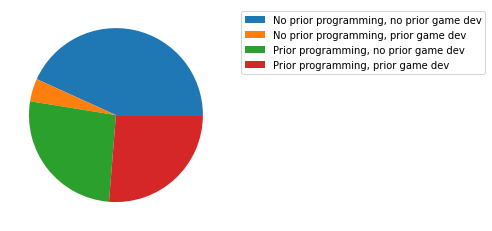

In [218]:
v2_dist = pd.crosstab(v2['Prior'], v2['PriorGameDev'], margins=False)
display(v2_dist)
pi_wedges = v2_dist.groupby(['Prior', 'PriorGameDev']).sum().values.flatten()
print(pi_wedges)
wedge_labels = ['No prior programming, no prior game dev', 'No prior programming, prior game dev', 'Prior programming, no prior game dev', 'Prior programming, prior game dev']
plt.pie(x=pi_wedges)
plt.legend(wedge_labels, bbox_to_anchor=(1.05, 1))
plt.show()


Compared to v1, different distribution of experience. Noticably more participants without prior levels of experience. 

In [219]:
make_cont_tables(v2, survey_headers)

OpenShape totals and contingency table based on prior experience
rectangle                                                                                                                                                               44
draw_rectangle                                                                                                                                                           5
rectangle()                                                                                                                                                              4
generate_rectangle                                                                                                                                                       4
create_rectangle                                                                                                                                                         3
i don't know                                                                    

OpenShape           ???  a  box  create_rectangle  create_rectangle()  \
Prior PriorGameDev                                                      
False No.             1  1    1                 3                   0   
      Yes.            0  0    0                 0                   0   
True  No.             0  0    0                 0                   1   
      Yes.            0  0    0                 0                   0   
All                   1  1    1                 3                   1   

OpenShape           create_square  createrectangle()  def create_rectangle  \
Prior PriorGameDev                                                           
False No.                       0                  0                     1   
      Yes.                      0                  0                     0   
True  No.                       0                  0                     0   
      Yes.                      1                  1                     0   
All                             1                  1                     1   

OpenShape           def rectangle ():  def rectangle()  defrectangle():  \
Prior PriorGameDev                                                        
False No.                           0                1                1   
      Yes.                          0                0                0   
True  No.                           1                0                0   
      Yes.                          0                1                0   
All                                 1                2                1   

OpenShape           determine(shape)  dian gu()  draw  draw("box")  draw_rect  \
Prior PriorGameDev                                                              
False No.                          1          0     1            0          0   
      Yes.                         0          1     0            0          0   
True  No.                          0          0     0            1          1   
      Yes.                         0          0     0            0          0   
All                                1          1     1            1          1   

OpenShape           draw_rectangle  draw_rectangle()  drawing()  \
Prior PriorGameDev                                                
False No.                        3                 0          0   
      Yes.                       0                 0          0   
True  No.                        1                 1          0   
      Yes.                       1                 0          1   
All                              5                 1          1   

OpenShape           drawrectangle()  empty_rectangle  form_rectangle  \
Prior PriorGameDev                                                     
False No.                         0                1               1   
      Yes.                        0                0               0   
True  No.                         0                0               0   
      Yes.                        1                0               0   
All                               1                1               1   

OpenShape           game shape  gen_rectangle  generate_rect  \
Prior PriorGameDev                                             
False No.                    0              1              0   
      Yes.                   0              0              0   
True  No.                    0              0              1   
      Yes.                   1              0              0   
All                          1              1              1   

OpenShape           generate_rectangle  \
Prior PriorGameDev                       
False No.                            2   
      Yes.                           0   
True  No.                            2   
      Yes.                           0   
All                                  4   

OpenShape           i am unsure as to the function that makes this shape.  \
Prior PriorGameDev                                 

OpenScreen totals and contingency table based on prior experience
border                                      32
screen                                       4
frame                                        4
play area                                    3
square                                       3
outline                                      2
boarder                                      2
candy frog                                   2
window                                       2
board                                        2
i don't know                                 2
game_area                                    2
main_screen                                  2
display                                      2
border or perimeter                          1
perimeter                                    1
area_of_square                               1
whitespace                                   1
a boarder                                    1
design function                          

OpenScreen          a boarder  a border  area  area_of_square  board  boarder  \
Prior PriorGameDev                                                              
False No.                   0         1     0               0      1        1   
      Yes.                  0         0     1               0      0        0   
True  No.                   0         0     0               1      1        1   
      Yes.                  1         0     0               0      0        0   
All                         1         1     1               1      2        2   

OpenScreen          body  border  border or perimeter  border_area  borders  \
Prior PriorGameDev                                                            
False No.              0      16                    0            1        1   
      Yes.             0       0                    0            0        0   
True  No.              0      12                    0            0        0   
      Yes.             1       4                    1            0        0   
All                    1      32                    1            1        1   

OpenScreen          boundary  box  candy frog  design function  display  \
Prior PriorGameDev                                                        
False No.                  0    0           0                1        0   
      Yes.                 1    0           0                0        0   
True  No.                  0    0           1                0        1   
      Yes.                 0    1           1                0        1   
All                        1    1           2                1        2   

OpenScreen          display or in game  display_screen  \
Prior PriorGameDev                                       
False No.                            1               1   
      Yes.                           0               0   
True  No.                            0               0   
      Yes.                           0               0   
All                                  1               1   

OpenScreen          empty space out of the square border  emulator  frame  \
Prior PriorGameDev                                                          
False No.                                              0         1      1   
      Yes.                                             1         0      0   
True  No.                                              0         0      1   
      Yes.                                             0         0      2   
All                                                    1         1      4   

OpenScreen          frame or border  game activity  game area  game bounds  \
Prior PriorGameDev                                                           
False No.                         1              1          1            0   
      Yes.                        0              0          0            0   
True  No.                         0              0          0            1   
      Yes.                        0              0          0            0   
All                               1              1          1            1   

OpenScreen          game screen  game screen perimeter  game space  game zone  \
Prior PriorGameDev                                                              
False No.                     1                      0           0          1   
      Yes.                    0                      0           0          0   
True  No.                     0                      1           1          0   
      Yes.                    0                      0           0          0   
All                           1                      1           1          1   

OpenScreen          game_area  game_window  gamescreen()  \
Prior PriorGameDev                                         
False No.                   0            0             0   
      Yes.                  0            1             0   
True  No.                   1            0        

ClosedScreen totals and contingency table based on prior experience
window    53
screen    22
scene     12
world      7
level      7
view       6
Name: ClosedScreen, dtype: int64
ClosedScreen by experience


ClosedScreen        level  scene  screen  view  window  world  All
Prior PriorGameDev                                                
False No.               1      2      12     3      28      5   51
      Yes.              0      0       2     0       3      0    5
True  No.               3      5       3     1      16      2   30
      Yes.              3      5       5     2       6      0   21
All                     7     12      22     6      53      7  107

ClosedMovement totals and contingency table based on prior experience
animation    50
glide        30
movement     23
action        5
Name: ClosedMovement, dtype: int64
ClosedMovement by experience


ClosedMovement      action  animation  glide  movement  All
Prior PriorGameDev                                         
False No.                2         28     10        11   51
      Yes.               0          3      2         0    5
True  No.                2         10     13         6   31
      Yes.               1          9      5         6   21
All                      5         50     30        23  108

ClosedWave totals and contingency table based on prior experience
animation    51
action       39
movement     18
Name: ClosedWave, dtype: int64
ClosedWave by experience


ClosedWave          action  animation  movement  All
Prior PriorGameDev                                  
False No.               14         28         9   51
      Yes.               1          1         3    5
True  No.               14         15         2   31
      Yes.              10          7         4   21
All                     39         51        18  108

ClosedStep totals and contingency table based on prior experience
repeat       61
iteration    38
step          7
update        2
Name: ClosedStep, dtype: int64
ClosedStep by experience


ClosedStep          iteration  repeat  step  update  All
Prior PriorGameDev                                      
False No.                  16      31     4       0   51
      Yes.                  1       4     0       0    5
True  No.                   9      18     3       1   31
      Yes.                 12       8     0       1   21
All                        38      61     7       2  108

ClosedEvent totals and contingency table based on prior experience
when        40
attach      23
connect     19
register    15
on          11
Name: ClosedEvent, dtype: int64
ClosedEvent by experience


ClosedEvent         attach  connect  on  register  when  All
Prior PriorGameDev                                          
False No.               12       12   4        10    13   51
      Yes.               1        0   1         1     2    5
True  No.                7        4   2         3    15   31
      Yes.               3        3   4         1    10   21
All                     23       19  11        15    40  108

ClosedState totals and contingency table based on prior experience
state     37
moment    35
status    33
world      3
Name: ClosedState, dtype: int64
ClosedState by experience


ClosedState         moment  state  status  world  All
Prior PriorGameDev                                   
False No.               18     18      13      2   51
      Yes.               3      1       1      0    5
True  No.                8     11      12      0   31
      Yes.               6      7       7      1   21
All                     35     37      33      3  108

OpenSprite totals and contingency table based on prior experience
characters                                                 16
objects                                                    12
candy                                                       6
character                                                   5
object                                                      5
items                                                       4
sprites                                                     4
entities                                                    3
sprite                                                      3
figures                                                     3
assets                                                      3
objectives                                                  2
figure                                                      2
animations                                                  2
icons                                                       2
i am

OpenSprite          animals  animations  assets  avatars  base  bubbles  bug  \
Prior PriorGameDev                                                             
False No.                 1           0       2        0     1        1    1   
      Yes.                0           0       0        0     0        0    0   
True  No.                 0           1       0        1     0        0    0   
      Yes.                0           1       1        0     0        0    0   
All                       1           2       3        1     1        1    1   

OpenSprite          candy  candy in the air  character  characters  \
Prior PriorGameDev                                                   
False No.               3                 0          2          11   
      Yes.              0                 1          1           0   
True  No.               1                 0          1           3   
      Yes.              2                 0          1           2   
All                     6                 1          5          16   

OpenSprite          characters, subjects and objects, targets  checkpoint  \
Prior PriorGameDev                                                          
False No.                                                   1           0   
      Yes.                                                  0           0   
True  No.                                                   0           1   
      Yes.                                                  0           0   
All                                                         1           1   

OpenSprite          cindy  components  cpu's  creature  elements  \
Prior PriorGameDev                                                 
False No.               0           1      0         1         1   
      Yes.              0           0      0         0         0   
True  No.               0           0      1         0         0   
      Yes.              1           0      0         0         0   
All                     1           1      1         1         1   

OpenSprite          elements, objects, figures, characters  entities  extras  \
Prior PriorGameDev                                                             
False No.                                                0         2       0   
      Yes.                                               0         0       1   
True  No.                                                1         0       0   
      Yes.                                               0         1       0   
All                                                      1         3       1   

OpenSprite          features  figure  figures  frog and bug  \
Prior PriorGameDev                                            
False No.                  1       1        2             0   
      Yes.                 0       0        0             0   
True  No.                  0       1        1             1   
      Yes.                 0       0        0             0   
All                        1       2        3             1   

OpenSprite          frog, candy, and ground  game  game components  \
Prior PriorGameDev                                                   
False No.                                 0     1                1   
      Yes.                                0     0                0   
True  No.                                 1     0                0   
      Yes.                                0     0                0   
All                                       1     1                1   

OpenSprite          game elements  game_enviro  \
Prior PriorGameDev                               
False No.                       1            0   
      Yes.                      0            0   
True  No.                       0            1   
      Yes.                      0            0   
All                             1            1   

OpenSprite          i am not sure what the highlighted elements are called.  \
Prior P

ClosedSprite totals and contingency table based on prior experience
objects       42
characters    33
sprites       27
images         2
pixels         1
drawables      1
pictures       1
Name: ClosedSprite, dtype: int64
ClosedSprite by experience


ClosedSprite        characters  drawables  images  objects  pictures  pixels  \
Prior PriorGameDev                                                             
False No.                   21          0       1       16         1       1   
      Yes.                   2          1       0        2         0       0   
True  No.                    7          0       1       13         0       0   
      Yes.                   3          0       0       11         0       0   
All                         33          1       2       42         1       1   

ClosedSprite        sprites  All  
Prior PriorGameDev                
False No.                11   51  
      Yes.                0    5  
True  No.                10   31  
      Yes.                6   20  
All                      27  107

# Compare Survey v1 and v2 Distributions




Compare responses from surveys 1 and 2 with Chi-Square Independence Test.

Perform Chi-Square Independence Test for every shared survey question. 

If significant difference based on survey version, investigate relationship between responses per survey version and prior experience. 

It was fairly easy to determine that these results are easily read from a pie chart. 


In [220]:
v1['Version'] = 1
v2['Version'] = 2
total = pd.concat([v1, v2])
total['ClosedSprite'] = total['ClosedSprite'].str.strip().str.lower()
total['OpenShape'] = total['OpenShape'].str.lower()
all_chi = perform_all_chi(total, survey_headers)
exp_chi = perform_exp_chi(total, survey_headers)
total_p_values = pd.DataFrame(list(zip(all_chi, exp_chi)), columns=['sliced by survey version', 'sliced by experience'], index=survey_headers).transpose()
print("P-Values from Chi Square Independence Test performed individually by survey version and experience level: ")
display(total_p_values)
print("P-Values from Chi Square Indpendence Test performed by experience level on responses with significant difference based on survey version: ")
version_headers = ['OpenShape', 'ClosedScreen', 'ClosedMovement']
exp_chi_version1 = perform_exp_chi(v1, version_headers)
exp_chi_version2= perform_exp_chi(v2, version_headers)
pd.DataFrame(list(zip(exp_chi_version1, exp_chi_version2)), columns=['v1', 'v2'], index=version_headers).transpose()

P-Values from Chi Square Independence Test performed individually by survey version and experience level: 


,OpenShape,OpenScreen,ClosedScreen,ClosedMovement,ClosedWave,ClosedStep,ClosedEvent,ClosedState,OpenSprite,ClosedSprite
sliced by survey version,0.008233,0.422553,1.857338e-12,0.000001,0.499849,0.222499,0.815481,0.069710,0.158248,0.647583
sliced by experience,0.333725,0.011658,7.237847e-03,0.249262,0.152158,0.237950,0.149999,0.040338,0.019545,0.001064


P-Values from Chi Square Indpendence Test performed by experience level on responses with significant difference based on survey version: 


,OpenShape,ClosedScreen,ClosedMovement
v1,0.185385,0.297430,0.786123
v2,0.818702,0.168839,0.494844


## Pooling V1 and V2 when appropriate
Maintain total responses from surveys for questions with no significant difference and unusable data ('OpenScreen' that did not measure proper concept). 

For each question: 
-  If significant difference was calculated between experience levels, investigate differences between subgroups
-  If no significant difference, investigate overall preferences 

In [221]:
upd_total = total.drop(['OpenShape', 'OpenScreen', 'ClosedScreen', 'ClosedMovement', 'OpenMovement'], axis=1)

#### ClosedWave 
No significant difference based on experience. 

Animation    82
Action       73
Movement     29
Name: ClosedWave, dtype: int64


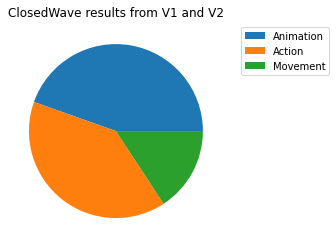

In [222]:
wave_total = upd_total['ClosedWave'].value_counts()
plt.pie(x=wave_total)
print(wave_total)
plt.title('ClosedWave results from V1 and V2')
plt.legend(['Animation', 'Action', 'Movement'], bbox_to_anchor=(1.05, 1))
plt.show()

'animation' and 'action' closely frequent. 

### ClosedStep 
No significant difference based on experience.

Repeat       99
Iteration    62
Step         19
Update        4
Name: ClosedStep, dtype: int64


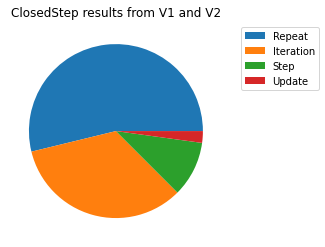

In [223]:
step_total = upd_total['ClosedStep'].value_counts()
plt.pie(x=step_total)
print(step_total)
plt.title('ClosedStep results from V1 and V2')
plt.legend(['Repeat', 'Iteration', 'Step', 'Update'], bbox_to_anchor=(1.05, 1))
plt.show()

'repeat' most frequent, 'iteration' also fairly popular.

### ClosedEvent
No significant difference based on experience.

When        75
Attach      36
Connect     31
Register    24
On          18
Name: ClosedEvent, dtype: int64


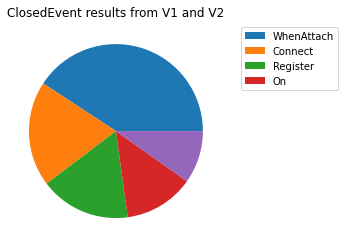

In [224]:
event_total = upd_total['ClosedEvent'].value_counts()
plt.pie(x=event_total)
print(event_total)
plt.title('ClosedEvent results from V1 and V2')
plt.legend(['When' 'Attach', 'Connect', 'Register', 'On'], bbox_to_anchor=(1.05, 1))
plt.show()

'when' evidently most common.

### ClosedState
Significant difference based on experience.

ClosedState by experience


ClosedState         moment  state  status  world  All
Prior PriorGameDev                                   
False No.               28     22      18      2   70
      Yes.               3      1       2      0    6
True  No.               12     21      19      0   52
      Yes.               7     30      18      1   56

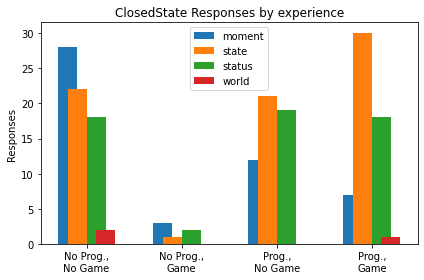

In [225]:
state_total = make_exp_table(upd_total, 'ClosedState')
# state_total.xs('No.', level='PriorGameDev') multi-indexing
# state_total['moment']
state_total = state_total.drop(labels="All", axis=0)
display(state_total)
# no_prior = state_total.iloc[0]
moment = state_total['moment']
# plt.bar(x =['moment', 'state', "status", 'world'], height=no_prior)
# plt.show()
# labels = ['moment', 'state', "status", 'world']
labels = ['No Prog.,\nNo Game', 'No Prog.,\nGame', 'Prog.,\nNo Game', 'Prog.,\nGame']
x = np.arange(len(labels))
width = .20
fig, ax = plt.subplots()
moment_bar = ax.bar(x - width, moment, width, label="moment")
# nppg = state_total.iloc[1]
state = state_total['state']
state_bar = ax.bar(x - width/2, state, width, label="state")
status = state_total['status']
status_bar = ax.bar(x + width/2, status, width, label='status')
world = state_total['world']
world_bar = ax.bar(x + width, world, width, label='world')
ax.set_title('ClosedState Responses by experience')
ax.set_ylabel('Responses')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()

As initially noticed in V1, 'moment' is more popular among participants without prior game development experience and not as popular among students with game development and programming experience. 'state' is still most popular overall. 

### OpenSprite 
Significant difference based on experience.

I don't even know how I'd visualize this. 

In [226]:
upd_total['OpenSprite'].dropna().apply(clean_text)
display(analyze_free_response(upd_total, 'OpenSprite', True))

OpenSprite by experience


OpenSprite          objects  characters  sprites  character  candy  object  \
Prior PriorGameDev                                                           
False No.                 8          14        2          2      3       3   
      Yes.                1           0        0          1      0       0   
True  No.                 9           8        3          1      1       3   
      Yes.               12           8       10          2      2       0   
All                      30          30       15          6      6       6   

OpenSprite          figures  elements  animations  items  entities  assets  \
Prior PriorGameDev                                                           
False No.                 2         3           0      1         2       2   
      Yes.                0         0           0      0         0       0   
True  No.                 3         0           2      2         1       1   
      Yes.                0         2           2      1         1       1   
All                       5         5           4      4         4       4   

OpenSprite          sprite  figure  objectives  game elements  icons  element  \
Prior PriorGameDev                                                              
False No.                0       2           1              1      1        1   
      Yes.               0       0           0              0      0        0   
True  No.                1       1           0              0      0        0   
      Yes.               2       0           1              1      1        1   
All                      3       3           2              2      2        2   

OpenSprite          item  mission  main parts  models  key  movingelement()  \
Prior PriorGameDev                                                            
False No.              0        0           1       0    0                0   
      Yes.             1        1           0       0    0                0   
True  No.              0        0           0       1    1                0   
      Yes.             1        0           0       0    0                1   
All                    2        1           1       1    1                1   

OpenSprite          animals  objects in the screen  pictures  player  \
Prior PriorGameDev                                                     
False No.                 1                      0         1       0   
      Yes.                0                      0         0       0   
True  No.                 0                      1         0       0   
      Yes.                0                      0         0       1   
All                       1                      1         1       1   

OpenSprite          sceneic_elements  special point or movement  table  \
Prior PriorGameDev                                                       
False No.                          0                          1      1   
      Yes.                         0                          0      0   
True  No.                          0                          0      0   
      Yes.                         1                          0      0   
All                                1                          1      1   

OpenSprite          the player and the objective  the subjects  the target  \
Prior PriorGameDev                                                           
False No.                                      0             0           1   
      Yes.                                     0             0           0   
True  No.                                      0             1           0   
      Yes.                                     1             0           0   
All                                            1             1           1   

OpenSprite          the verbs. values  things  virtual item  parts  game  \
Prior PriorGameDev                                                         
False No.                           1       1             0  

### Closed Sprite
Signficantly difference based on experience. 

ClosedSprite by experience


ClosedSprite        All  objects  characters  sprites  images  drawables  \
Prior PriorGameDev                                                         
False No.            70       28          25       14       1          0   
      Yes.            6        3           2        0       0          1   
True  No.            52       20          17       14       1          0   
      Yes.           55       26          10       19       0          0   

ClosedSprite        pictures  pixels  
Prior PriorGameDev                    
False No.                  1       1  
      Yes.                 0       0  
True  No.                  0       0  
      Yes.                 0       0

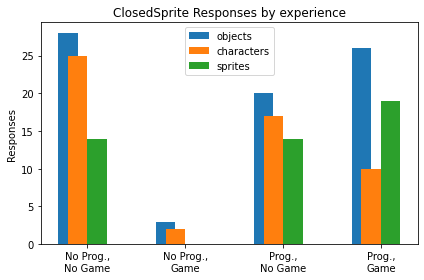

In [227]:
sprite = make_exp_table(upd_total, 'ClosedSprite').sort_values(('All',''), axis=1, ascending=False)
sprite = sprite.drop(labels="All", axis=0)
display(sprite)
objects = sprite['objects']
labels = ['No Prog.,\nNo Game', 'No Prog.,\nGame', 'Prog.,\nNo Game', 'Prog.,\nGame']
x = np.arange(len(labels))
width = .20
fig, ax = plt.subplots()
objects_bar = ax.bar(x - width, objects, width, label="objects")
characters = sprite['characters']
char_bar = ax.bar(x - width/2, characters, width, label="characters")
sprites = sprite['sprites']
sprites_bar = ax.bar(x + width/2, sprites, width, label='sprites')
ax.set_title('ClosedSprite Responses by experience')
ax.set_ylabel('Responses')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()

More participants without prior game development experience preferred characters. Objects most popular overall. 

## When V1 and V2 data cannot be pooled
Investigating responses with signficant differences between V1 and V2.

## OpenShape

In [228]:
total['OpenShape'] = total['OpenShape'].apply(clean_text)
analyze_free_response(total, 'OpenShape', False)

OpenShape contingency table


OpenShape,rectangle,draw_rectangle,nan,make_rectangle,create_rectangle,generate_rectangle,shape,draw_square,rect,generate_rect,square,make_rect,makerectangle,draw_rect,i don't know,"name: rec. description: rec returns a rectangle after given its length and width. syntax: rec(length,width). parameters: length(int), width(int). returns: rectangle",make_box,print,???,rectangle :,"rectangle(length: int, width: int) -> int:",rectangle:,rectangle_shape,rectangle_shape(shape: str)->str:,return function,shape = rectangle,shape_rectangle,t.foward.t.left.t.down.t.right,turtle,turtle.movement,integer,generate_square,i do not know,i am unsure as to the function that makes this shape.,a_rectangle,black_rectangle,box,create_shape,create_square,createrectangle,cuboid,determine(shape),dian gu,draw,"draw(""box"")",drawing,drawrectangle,empty_rectangle,firstrectangle,form_rectangle,g_rectangle,game shape,gen_rectangle,generate.rectangle,a,ziang zhou
Version,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,11,16,0,11,7,2,2,4,2,1,2,1,1,1,0,0,1,0,0,0,1,0,1,1,0,0,1,0,1,0,1,1,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
2,51,6,14,1,5,4,3,0,2,1,0,1,1,1,2,1,0,1,1,1,0,1,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,1,1,0,1,1,1,1,1,1,1,0,1,0,1,1,0,1,1
All,62,22,14,12,12,6,5,4,4,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


`rectangle` more popular in V2, `draw_rectangle` more popular in V1. 

## ClosedScreen
Significant based on survey version. 
Visualizations are weird with added option.

ClosedScreen contingency table


ClosedScreen,All,Window,Screen,View,Scene,World,Level,Camera
Version,,,,,,,,
1,76,0,30,23,15,4,2,2
2,107,53,22,6,12,7,7,0
All,183,53,52,29,27,11,9,2


ClosedScreen,Window,Screen,View,Scene,World,Level,Camera
Version,,,,,,,
1,0,30,23,15,4,2,2
2,53,22,6,12,7,7,0
All,53,52,29,27,11,9,2


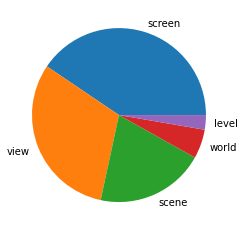

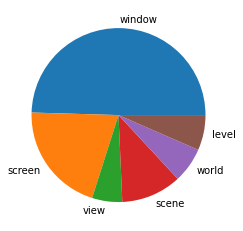

In [229]:
closed_tot = (make_table_by_q(total, 'ClosedScreen').sort_values(by='All', axis=1, ascending=False))
display(closed_tot)
# Michael thinks two pie charts for results based on version
closed_tot = closed_tot.drop(labels="All", axis=1)
display(closed_tot)
labels = ['window', 'screen', 'view', 'scene', 'world', 'level']
labels_v1 = labels[1:]
v1_data = closed_tot.iloc[0]
v1_data = v1_data[1:6]
# print(labels_v1)
v2_data = closed_tot.iloc[1]
v2_data = v2_data[:6]
#ax1, ax2 = plt.subplot()
# nppg = state_total.iloc[1]
v1_pi = plt.pie(v1_data, labels = labels_v1)
plt.show()
v2_pi = plt.pie(v2_data, labels=labels)
plt.show()

Not including 'window' in V1 affected results. V2 suggests 'window' is popular option, 'screen' as second option. 
## ClosedMovement

ClosedMovement contingency table


ClosedMovement,Action,Animation,Glide,Movement
Version,,,,
1,3,7,33,33
2,5,50,30,23
All,8,57,63,56


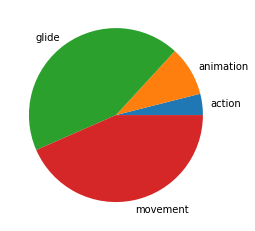

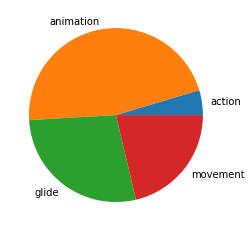

In [230]:
movement_tot = make_table_by_q(total, 'ClosedMovement')
movement_tot = movement_tot.drop(labels="All", axis=1)
display(movement_tot)
labels = ['action', 'animation', 'glide', 'movement']
v1_data = movement_tot.iloc[0]
v2_data = movement_tot.iloc[1]
v1_pi = plt.pie(v1_data, labels = labels)
plt.show()
v2_pi = plt.pie(v2_data, labels=labels)
plt.show()

'animation' more popular. Difference from V1 and V2 was wording changed to manage bias. Obviously, significant difference, suggests wording affects participant perception and bias. 
# Open-Ended Coding Question
Observe distributions and patterns in separate V1 and V2 data. 

V1: 


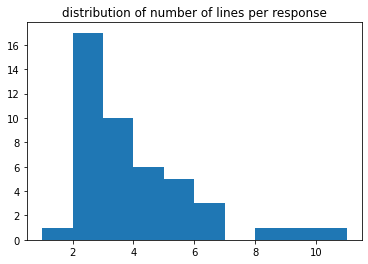

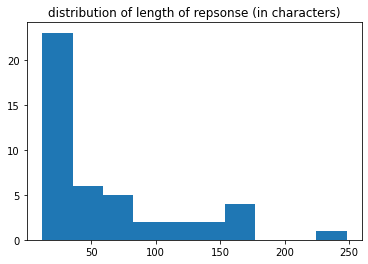

Num Lines Normality on an interval of .05:  0.8001936078071594 2.4016699171625078e-06 True
Num Characters Normality on an interval of .05:  0.7900149822235107 1.4448777392317425e-06 True

Broken: 6; Working: 70
{'methods': 18, 'functions': 15, 'both': 2, 'test cases': 0, 'graphics': 0, 'pens': 0, 'for': 3, 'while': 2, 'if': 2, 'func def': 7}
V2: 


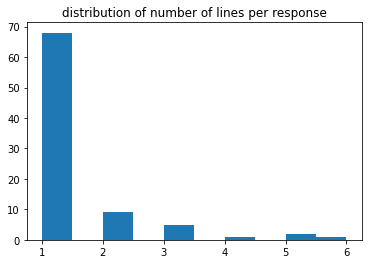

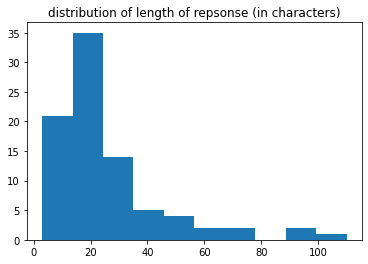

Num Lines Normality on an interval of .05:  0.4858640432357788 7.884292787326171e-16 True
Num Characters Normality on an interval of .05:  0.7452929019927979 6.568793425865138e-11 True

Broken: 34; Working: 84
{'methods': 31, 'functions': 11, 'both': 1, 'test cases': 0, 'graphics': 0, 'pens': 0, 'for': 0, 'while': 1, 'if': 2, 'func def': 5}


In [231]:
print('V1: ')
print(analyze_open_end(v1, 'GameDevOpenCode'))
print('V2: ')
print(analyze_open_end(v2, 'GameDevOpenCode'))

All p-values are less than 0.05, meaning we reject the null hypothesis that line or character length of either survey version are normally distributed. Because these values are not normally distributed, we can perform Mann Whitney U tests to compare the version one and version two responses. 

In [232]:
v1_char_line = avg_lines_char(v1, 'GameDevOpenCode')
v2_char_line = avg_lines_char(v2, 'GameDevOpenCode')
line_mwu, line_mwu_p = st.mannwhitneyu(x=v1_char_line[0], y=v2_char_line[0])
char_mwu, char_mwu_p = st.mannwhitneyu(x=v1_char_line[1], y=v2_char_line[1])
print(line_mwu_p, char_mwu_p)

1.1529999803013193e-16 1.8128938277980706e-06


both p-values comparing line and character numbers are significantly small, less than 0.05, so we reject the null hypothesis that there are no statistically significant differences of response length and survey version. This suggests responses cannot be compared together and should instead be looked at separately. 

In [233]:
def attrib(code):
    clear_report()
    code = str(code)
    calls = find_asts("Call", code)
    num_for = len(find_asts("For", code))
    num_while = len(find_asts("While", code))
    num_assign = len(find_asts("Assign", code))
    num_def = len(find_asts("FunctionDef", code))
    called_functions = [get_called_function(c.func) for c in calls]
    call = False
    for c in calls: 
        if (c.func.ast_name == "Name") or (c.func.ast_name == "Attribute"): 
            call = True
        else: 
            call = False
    try:
        code = str(code)
        ast.parse(code)
        working = True
    except SyntaxError:
        working = False
    if code == 'nan':
         return "empty"
    elif num_def:
        return "function definition"
    elif num_for or num_while:
        return "other construct"
    elif call:
        return "method/function call"
    elif num_assign:
        return "assignment"
    elif '#' in code or "'''" in code or '"""' in code:
        return "comment"
    elif not working: 
         return "did not compile"

def open_by_version(df):
    return df.groupby(['Prior', 'PriorGameDev'])['GameDevOpenCode'].apply(attrib).count()


Classify responses based on conventions

In [237]:
def open_by_version(df):
    classified = df.assign(classification=df.GameDevOpenCode.apply(attrib))
    grouped_classes = classified.groupby(['Prior', 'PriorGameDev']).classification
    classes_counts = grouped_classes.value_counts()
    return classes_counts.unstack().fillna(0).astype(int)
# display(open_by_version(pd.concat([v1, v2])).loc[(False,  'No.')])
v1_open = open_by_version(v1).loc[False,'No.']
v1_open = v1_open.div(v1_open.agg(sum)).multiply(100).round(1)
display(v1_open)
v2_open = open_by_version(v2).loc[False, 'No.']
v2_open = v2_open.div(v2_open.agg(sum)).multiply(100).round(1)
display(v2_open)
# ax = plt.subplot()
# pd.plotting.table(ax, data=v2_open)
open_total = pd.concat([v1_open, v2_open], axis = 1)
open_total.columns = ['V1', 'V2']
open_total = open_total.transpose()
# open_total.drop(['comment', 'function definition'], axis=1)
open_total = open_total.fillna(0)
open_total

classification
assignment               0.0
comment                  0.0
did not compile         16.7
empty                   38.9
function definition      5.6
method/function call    33.3
other construct          5.6
Name: (False, No.), dtype: float64

classification
assignment               2.1
did not compile         39.6
empty                   22.9
method/function call    35.4
other construct          0.0
Name: (False, No.), dtype: float64

classification,assignment,comment,did not compile,empty,function definition,method/function call,other construct
V1,0.0,0.0,16.7,38.9,5.6,33.3,5.6
V2,2.1,0.0,39.6,22.9,0.0,35.4,0.0


Get names of methods and functions called in responses

In [235]:
def get_name(node):
    if isinstance(node.astNode, ast.Name):
        return node.id
    elif isinstance(node.astNode, ast.Attribute):
        return f"{get_name(node.value)}.{node.attr}"
def find_calls(code):
    clear_report()
    return [get_name(c.func) for c in find_asts("Call", code)]
calls = pd.concat([v2]).GameDevOpenCode.fillna("").apply(find_calls)
pd.Series(calls.sum()).value_counts()

frog.right           6
move_frog            4
glide                3
print                2
move_right           2
character            2
move                 2
right                1
frog_move_right      1
input                1
turtle.Turtle        1
move.frog            1
Run_frog             1
turtle.right         1
move_object_right    1
frog.left            1
forward              1
frog_slide           1
frog.forward         1
moveForward          1
frog.setx            1
glide_right          1
moveSprite           1
step_right           1
move_left            1
frog.slide           1
loop                 1
move_LR              1
moveLeft             1
movement             1
frog.glide           1
turtle.forward       1
move_sprite          1
dtype: int64